# Homework 4: Implementation


In [1]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import KDTree
from sklearn.metrics import pairwise_distances

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
from scipy.sparse.linalg import eigsh


## Toy dataset generation


In [2]:
def toy_dataset(samples: int, type: str) -> NDArray:
    """Generate a toy dataset for the implementation part of the homework. We
    start with a 3D swiss roll or a 3D multivariate normal distribution and
    add 7 dimension of Gaussian noise.

    Parameters:
        - samples: number of samples in the dataset
        - type: either 'swiss_roll' or 'normal'

    Returns:
        - X: shape (samples, 10), the toy dataset
    """
    if type == 'swiss_roll':
        # Generates a 3D swiss roll in approx. [-10, 13] x [0, 21] x [-12, 15]
        X, _ = make_swiss_roll(n_samples=samples, random_state=1)
    elif type == 'normal':
        cov = np.array(
            [
                [6, 5, 0.5],
                [5, 20, -7],
                [0.5, -7, 8],
            ]
        )
        X = np.random.multivariate_normal(np.zeros(3), cov, samples)
    else:
        raise ValueError(f'Unknown type {type}')

    X = np.hstack([X, np.random.randn(samples, 7) / 2])
    return X

In [3]:
swiss_roll = toy_dataset(2000, 'swiss_roll')
normal = toy_dataset(2000, 'normal')

# Take radius for the color
swiss_roll_colors = swiss_roll[:, 0] ** 2 + swiss_roll[:, 2] ** 2

# Take the distance from the mean for the color
normal_mean = np.mean(normal[:, :3], axis=0)
normal_colors = np.linalg.norm(normal[:, :3] - normal_mean, axis=1)

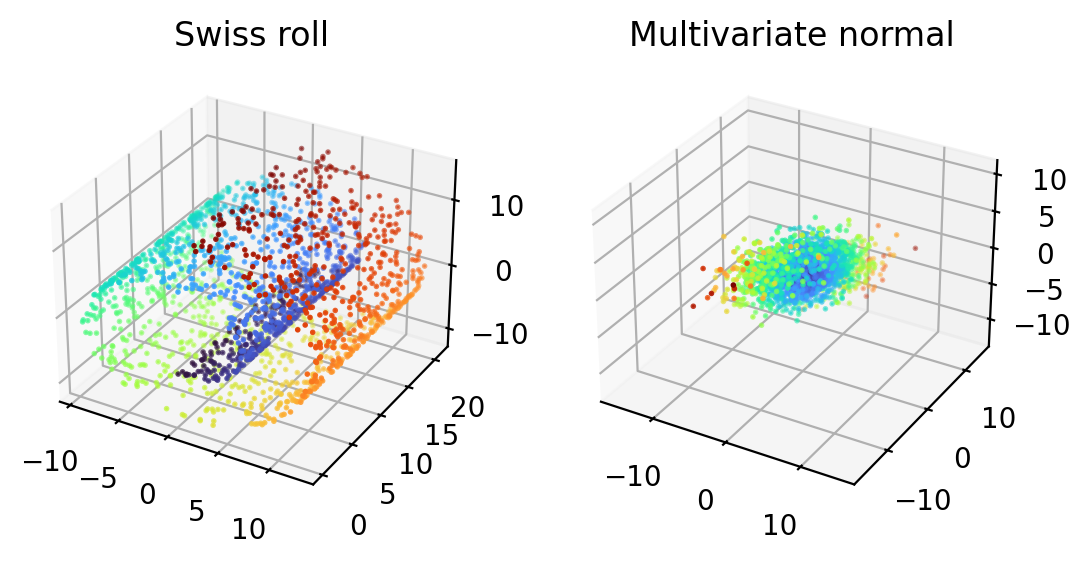

In [4]:
colors = swiss_roll[:, 0] ** 2 + swiss_roll[:, 2] ** 2
colors = (colors - colors.min()) / (colors.max() - colors.min())

fig = plt.figure()

x, y, z = swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2]
left = fig.add_subplot(121, projection='3d')
left.scatter(x, y, z, c=colors, s=1, cmap='turbo')
left.set_title('Swiss roll')

x, y, z = normal[:, 0], normal[:, 1], normal[:, 2]
right = fig.add_subplot(122, projection='3d')
right.scatter(x, y, z, c=normal_colors, s=1, cmap='turbo')
right.set_title('Multivariate normal')


plt.axis('equal')
plt.show()

## 1 Principal Component Analysis


In [43]:
def pca(data: NDArray, dimensions: int) -> tuple[NDArray, NDArray, NDArray]:
    """Compute the PCA of the data. Return the embedding, rotation matrix and
    the proportion of variance explained by each dimension. The data should be
    centered before computing PCA.

    Parameters:
        - data: shape (samples, features), the data to compute PCA on
        - dimensions: number of embedding dimensions

    Returns:
        - X_pca: shape (samples, dimensions), embedding of the data
        - components: shape (features, dimensions), the rotation matrix
        - explained_variance: shape (dimensions,), variance of each dimension
    """
    mean = np.mean(data, axis=0)
    centered = data - mean
    cov = centered.T @ centered / data.shape[0]

    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Select dimensions largest eigenvalues
    indices = np.argsort(eigenvalues)[: -dimensions - 1 : -1]

    components = eigenvectors[:, indices]
    explained_variance = eigenvalues[indices] / np.sum(eigenvalues)

    # Project each data point to the new basis
    X_pca = data @ components

    return X_pca, components, explained_variance

In [8]:
def plot_results(
    embeddings: tuple[NDArray, NDArray],
    colors: tuple[NDArray, NDArray],
    figsize: tuple[int, int] = (8, 4),
) -> None:
    fig = plt.figure(figsize=figsize)

    for embedding, color, title, subplot in zip(
        embeddings,
        colors,
        ['Swiss roll', 'Multivariate normal'],
        [121, 122],
    ):
        x, y = embedding[:, 0], embedding[:, 1]
        ax = fig.add_subplot(subplot)
        ax.scatter(x, y, c=color, cmap='turbo', s=1)
        ax.set_title(title)
        ax.axis('equal')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

Explained variance (Swiss roll): 0.41, 0.31
Explained variance (Multivariate normal): 0.67, 0.21


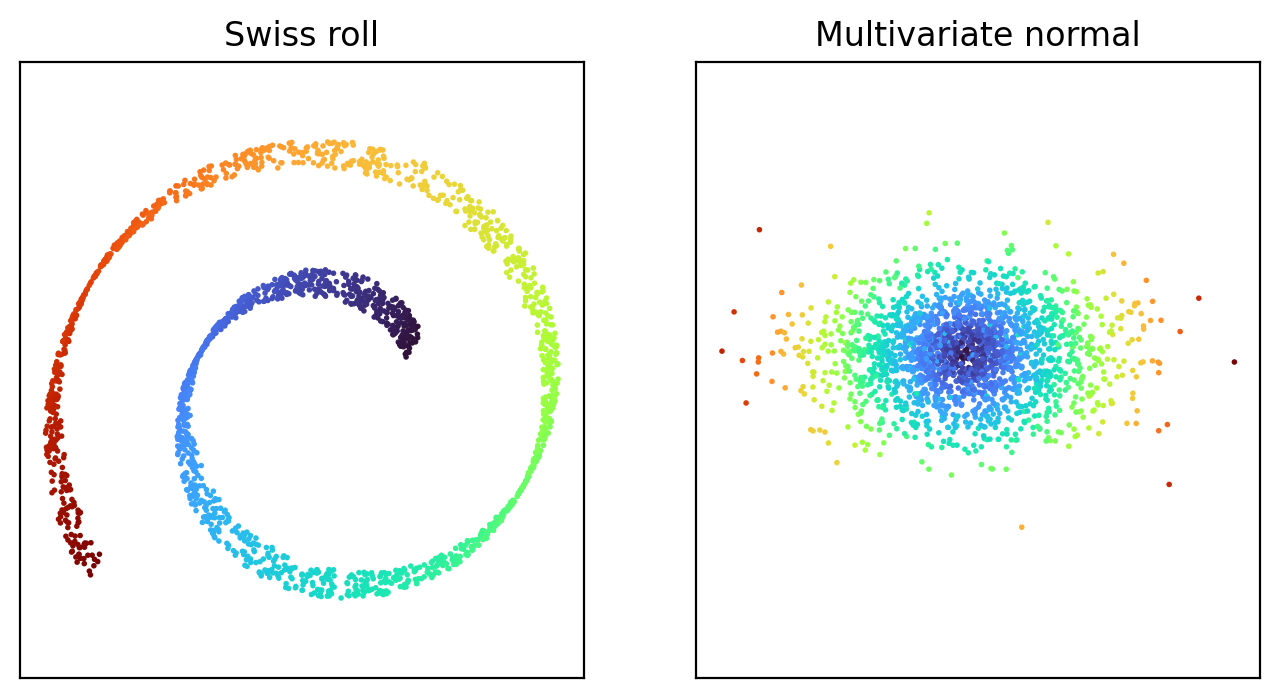

In [45]:
def pca_results(datasets: NDArray, colors: NDArray):
    swiss_roll_pca, _, explained_variance = pca(datasets[0], 2)
    print(
        'Explained variance (Swiss roll):',
        ', '.join(explained_variance.round(2).astype(str)),
    )

    normal_pca, _, explained_variance = pca(datasets[1], 2)
    print(
        'Explained variance (Multivariate normal):',
        ', '.join(explained_variance.round(2).astype(str)),
    )

    plot_results([swiss_roll_pca, normal_pca], colors)


pca_results([swiss_roll, normal], [swiss_roll_colors, normal_colors])

## 2 ISOMAP


In [56]:
def isomap(data: NDArray, dimensions: int, k: int) -> NDArray:
    """Compute the Isomap embedding of the data. Embedding tries to retain the
    geodesic distances between points, which are approximated by the shortest
    path in the k-nearest neighbors graph.

    Parameters:
        - data: shape (samples, features), the data to compute Isomap on
        - dimensions: number of embedding dimensions
        - k: number of neighbors to construct the neighbors graph

    Returns:
        - X_isomap: shape (samples, dimensions), the Isomap embedding
    """
    # Find the k-nearest neighbors using k-d tree
    kdtree = KDTree(data, leaf_size=10)
    distances, neighbors = kdtree.query(data, k + 1)
    # Remove self-distance and neighbor
    distances, neighbors = distances[:, 1:], neighbors[:, 1:]

    # Graph construction and Floyd-Warshall algorithm
    n = data.shape[0]
    row_ind = np.repeat(np.arange(n), k)
    col_ind = neighbors.ravel()
    weights = distances.ravel()
    adjacency = csr_matrix((weights, (row_ind, col_ind)), (n, n))
    distances = floyd_warshall(adjacency, directed=False)

    # Double center the squared distance matrix
    centering = np.eye(n) - np.ones((n, n)) / n
    kernel = -0.5 * centering @ (distances**2) @ centering

    # Compute embedding using eigendecomposition of kernel and Y = V Lambda^{1/2}
    eigenvalues, eigenvectors = np.linalg.eigh(kernel)
    indices = np.argsort(eigenvalues)[: -dimensions - 1 : -1]
    return eigenvectors[:, indices] * np.sqrt(eigenvalues[indices])

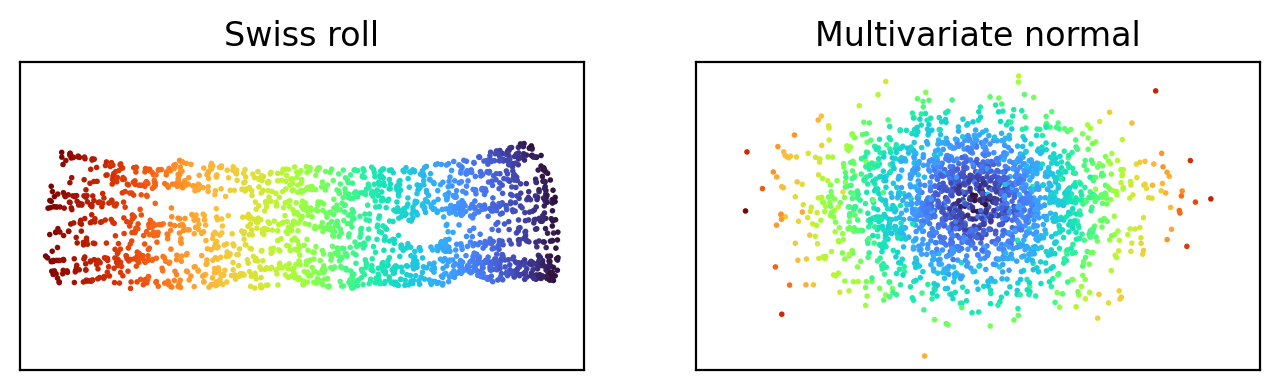

In [57]:
def isomap_results(datasets: NDArray, colors: NDArray):
    swiss_roll_isomap = isomap(datasets[0], 2, 10)
    normal_isomap = isomap(datasets[1], 2, 10)
    plot_results([swiss_roll_isomap, normal_isomap], colors, figsize=(8, 2))


isomap_results([swiss_roll, normal], [swiss_roll_colors, normal_colors])

## 3 Locally Linear Embedding


In [6]:
def compute_weights(
    point: NDArray, neighbors: NDArray, reg: float, least_sq: bool = False
) -> NDArray:
    """Compute the LLE weights to reconstruct the point from its neighbors.

    Parameters:
        - point: shape (features,), the point to reconstruct
        - neighbors: shape (k, features), the neighbors of the point
        - reg: regularization parameter for the Gram matrix
        - least_sq: use least squares instead of paper formula

    Returns:
        - weights: shape (k,), the weights to reconstruct the point with sum 1
    """
    if least_sq:
        solution = np.linalg.lstsq(neighbors.T, point, rcond=None)[0]
        return solution / np.sum(solution)

    k = neighbors.shape[0]
    to_center = np.outer(np.ones(k), point) - neighbors
    gram = to_center @ to_center.T + reg * np.eye(k)
    gram_inv = np.linalg.inv(gram)
    return gram_inv @ np.ones(k) / (np.ones(k) @ gram_inv @ np.ones(k))


def lle(data: NDArray, dimensions: int, k: int, reg=1e-3) -> NDArray:
    """Compute The Locally Linear Embedding of the data. Embedding tries to
    retain local weights between points.

    Parameters:
        - data: shape (samples, features), the data to compute LLE on
        - dimensions: number of embedding dimensions
        - k: number of neighbors to compute the local weights

    Returns:
        - X_lle: shape (samples, dimensions), the LLE embedding
    """
    # Find the k-nearest neighbors using k-d tree
    kdtree = KDTree(data, leaf_size=10)
    # The first column is the point itself (distance 0)
    neighbors = kdtree.query(data, k + 1, return_distance=False)

    # Compute reconstruction weights (remove self-point from neighbors)
    weights = np.array(
        [
            compute_weights(point, data[neighborhood], reg=reg)
            for point, neighborhood in zip(data, neighbors[:, 1:])
        ]
    )

    # Create Laplacian matrix with one 1 and k negative weights in each row
    n = data.shape[0]
    row_ind = np.repeat(np.arange(n), k + 1)
    col_ind = np.ravel(neighbors)
    elements = np.hstack([np.ones((n, 1)), -weights]).ravel()
    laplacian = csr_matrix((elements, (row_ind, col_ind)), (n, n))

    # Compute embedding using paper's eigenvalue problem MY = Y (1/n * Lambda)
    laplacian_gram = laplacian.T @ laplacian
    eigenvectors = eigsh(
        laplacian_gram, k=dimensions + 1, sigma=0.0, tol=1e-6, maxiter=500
    )[1]

    # Skip the eigenvector with the smallest eigenvalue (0)
    return eigenvectors[:, 1:]

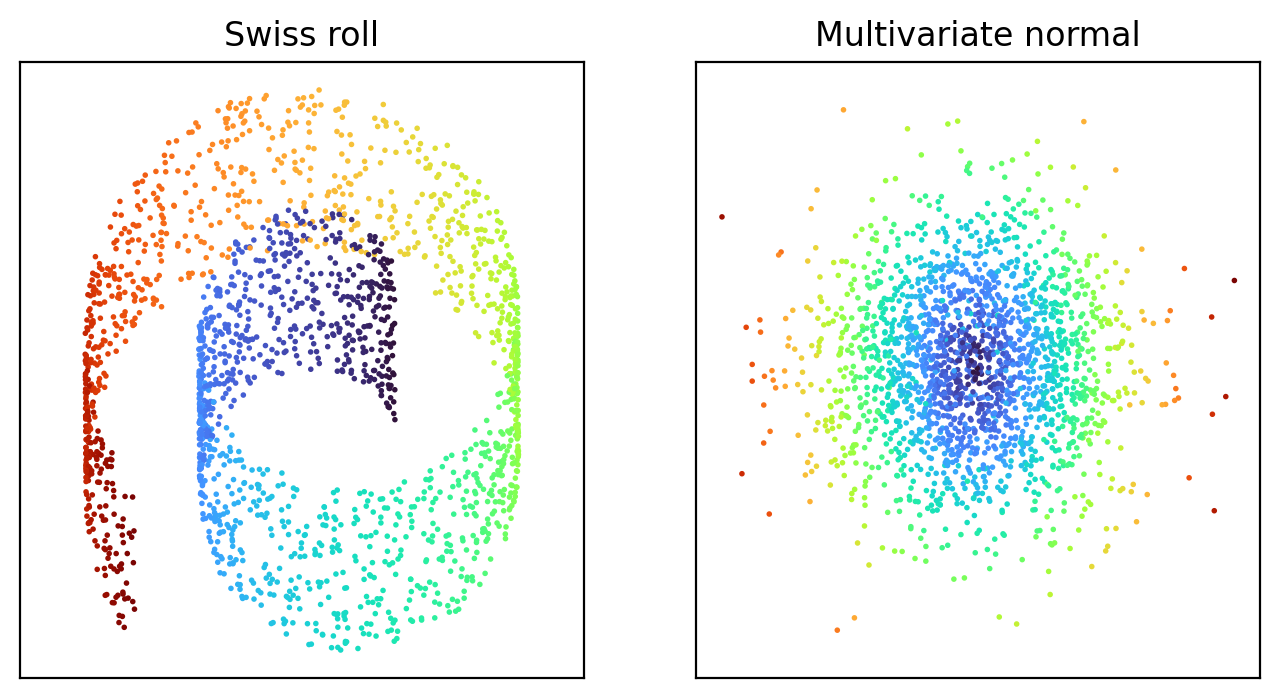

In [12]:
def lle_results(datasets: NDArray, colors: NDArray):
    swiss_roll_lle = lle(datasets[0], 2, 600)
    normal_lle = lle(datasets[1], 2, 85)
    plot_results([swiss_roll_lle, normal_lle], colors)


lle_results([swiss_roll, normal], [swiss_roll_colors, normal_colors])

### Selecting number of neighbors

Implemented from paper *Selection of the number of neighbours of each data
point for the Locally Linear Embedding Algorithm* by Rasa Karbauskaitė,
Olga Kurasova, Gintautas Dzemyda.

In [107]:
def rank_correlation(high_dim_data, low_dim_data):
    high_dim_distances = pairwise_distances(high_dim_data)
    low_dim_distances = pairwise_distances(low_dim_data)
    high_dim_rank = np.argsort(np.argsort(high_dim_distances, axis=1), axis=1)
    low_dim_rank = np.argsort(np.argsort(low_dim_distances, axis=1), axis=1)

    # Formula from the paper
    T = high_dim_data.shape[0]
    rhos = [
        1 - 6 * np.sum((high - low) ** 2) / (T**3 - T)
        for high, low in zip(high_dim_rank, low_dim_rank)
    ]
    return np.mean(rhos)


def select_lle_k(data: NDArray, ks: NDArray) -> tuple[int, NDArray]:
    rhos = np.zeros(ks.shape)

    for i, k in enumerate(ks):
        rho = rank_correlation(data, lle(data, 2, k))
        rhos[i] = rho

    return ks[np.argmax(rhos)], rhos

In [127]:
swiss_roll_k, swiss_roll_rhos = select_lle_k(swiss_roll, np.arange(10, 701, 30))

In [128]:
normal_k, normal_rhos = select_lle_k(normal, np.arange(5, 101, 5))

In [129]:
print('Best k for Swiss roll:', swiss_roll_k)
print('Best k for Multivariate normal:', normal_k)

Best k for Swiss roll: 640
Best k for Multivariate normal: 85


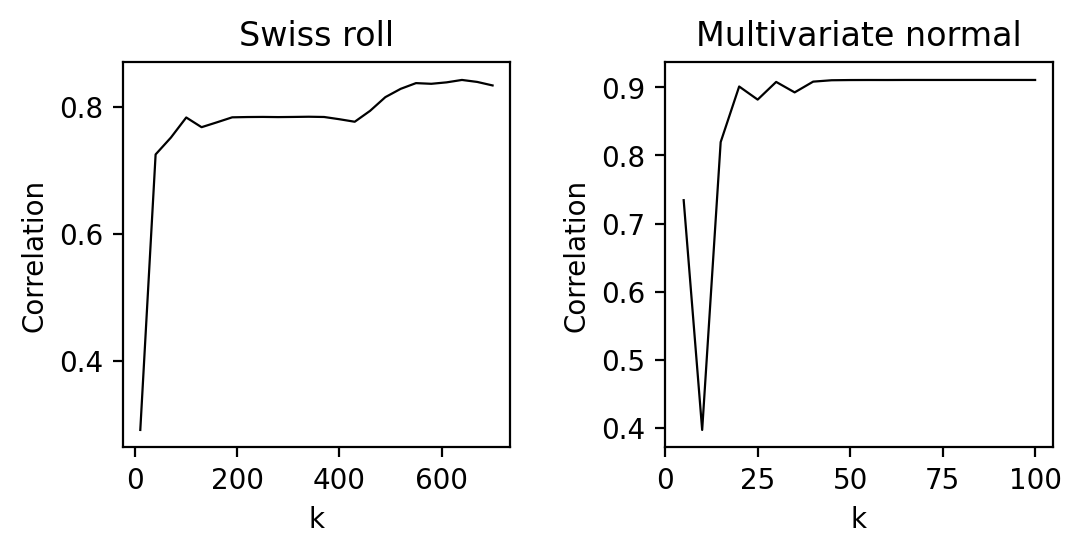

In [130]:
plt.figure(figsize=(6, 2.5))

plt.subplot(121)
plt.plot(np.arange(10, 701, 30), swiss_roll_rhos, c='black', linewidth=0.8)
plt.title('Swiss roll')
plt.xlabel('k')
plt.ylabel('Correlation')

plt.subplot(122)
plt.plot(np.arange(5, 101, 5), normal_rhos, c='black', linewidth=0.8)
plt.xticks([0, 25, 50, 75, 100])
plt.title('Multivariate normal')
plt.xlabel('k')
plt.ylabel('Correlation')

plt.subplots_adjust(wspace=0.4)
plt.show()